# Code

> by Hogeon Kim

# Data Preprocess
가공된 data는 코드 안에 있기 때문에 원본 data와 코드가 있으면 가공 data를 확인할 수 있음 - 별첨X

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

한글 data를 다루기 위한 iso코드

In [2]:
iso_kor = pd.read_csv("data/Korea_ISO.csv", encoding='euc-kr').iloc[1:,[0,4]] # 한글 국가명과 ISO(alpha-2) code 대응
iso_kor.columns = ['kor_name', 'alpha-2']
iso_kor = iso_kor.set_index('alpha-2')
iso_eng = pd.read_csv("data/English_ISO.csv").iloc[:,[0,1]].set_index('alpha-2')
df_iso = iso_eng.join(iso_kor)
df_iso
# 국가 iso 코드를 이용한 한/영 변환

,name,kor_name
alpha-2,,
AF,Afghanistan,아프가니스탄
AX,Åland Islands,NaN
AL,Albania,알바니아
DZ,Algeria,알제리
AS,American Samoa,미국령사모아
...,...,...
WF,Wallis and Futuna,왈리스푸트나
EH,Western Sahara,NaN
YE,Yemen,예멘


## 국가별 코로나-19 확진자/사망자 통계 : 대표 `feature`들과 연관시킬 key data

- 100,000명당 국가별 코로나-19 확진자/사망자 수

In [3]:
df_cov = pd.read_csv("data/WHO-COVID-19-global-table-data.csv")
df_cov = df_cov.iloc[1: , [3,8]]/1000 # 100,000명 당 누적 확진자수, 100,000명 당 누적 사망자 수 추출 후 %로 변환
df_cov.columns = ['Cases','Deaths']
df_cov = df_cov[df_cov[:] > 0] # Data가 무의미한 나라 제거
df_cov = df_cov.dropna() # NaN Value 제거
df_cov

,Cases,Deaths
United States of America,281.955,2.323
India,3.343,0.032
France,175.240,0.381
Germany,166.394,0.066
Brazil,54.974,0.215
...,...,...
Curaçao,0.029,0.001
Aruba,0.071,0.001
Saint Lucia,0.038,0.001
Gibraltar,0.045,0.002


- 코로나-19에 대한 국가별 치사율

`df_cov`의 사망자 비율을 확진자 비율로 나누어 치사율(Lethality)를 계산.
\begin{align*}
Lethality = \frac{Deaths}{Cases}
\end{align*}


계산한 `lethality`에 기존의 `df_cov`에서의 index를 가져와 병합해서 새로운 dataframe 생성.

In [4]:
lethality = (df_cov['Deaths']/df_cov['Cases'])*100
df_lethality = pd.DataFrame(lethality)
df_lethality.columns = ['Lethality']
df_lethality.head()

,Lethality
United States of America,0.823890
India,0.957224
France,0.217416
Germany,0.039665
Brazil,0.391094


- 기존의 확진자/사망자 수와 치사율을 병합해 `key data` 형성

In [5]:
df_covid19 = df_cov.join(df_lethality)
df_covid19.head()

,Cases,Deaths,Lethality
United States of America,281.955,2.323,0.823890
India,3.343,0.032,0.957224
France,175.240,0.381,0.217416
Germany,166.394,0.066,0.039665
Brazil,54.974,0.215,0.391094


- Outlier 식별을 위해 boxplot 그리기

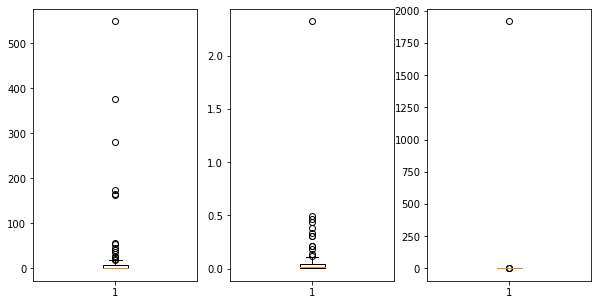

In [6]:
f, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].boxplot(df_covid19['Cases'])
ax[1].boxplot(df_covid19['Deaths'])
ax[2].boxplot(df_covid19['Lethality'])

plt.show()

10,000명 당 확진자 수가 10,000명 이상인 outlier국가(ex.미국)들을 살펴본 결과, data가 대략 10배정도 늘어난 형태였음을 확인.

10,000명 당 사망자 수가 10,00명 이상인 outlier국가(ex.미국)들을 살펴본 결과, data가 대략 10배정도 늘어난 형태였음을 확인.

Lethality가 너무 높은 outlier 제거

In [7]:
df_covid19['Cases'] = df_covid19['Cases'].apply(lambda x: x/10 if x > 100 else x)
df_covid19['Deaths'] = df_covid19['Deaths'].apply(lambda x: x/10 if x > 1 else x)
df_covid19 = df_covid19[df_covid19['Lethality']<1000]

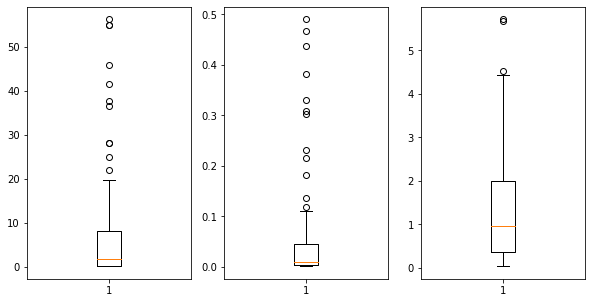

In [8]:
f, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].boxplot(df_covid19['Cases'])
ax[1].boxplot(df_covid19['Deaths'])
ax[2].boxplot(df_covid19['Lethality'])

plt.show() # outlier 제거 확인

## 국가별 백신 접종 현황

In [9]:
df_vac = pd.read_csv('data/vaccination-data.csv')
df_vac = df_vac[['COUNTRY','PERSONS_FULLY_VACCINATED_PER100']].dropna() # 국가별 백신 접종률(%) 추출/NaN value 제거
df_vac.columns = ['','Vaccinated%']
df_vac = df_vac[df_vac['Vaccinated%'] <100]
df_vac = df_vac[df_vac['Vaccinated%'] > 1] # Data가 무의미(0에 근접 or 100이상)한 나라 제거
df_vac = df_vac.set_index('')
df_vac.head()

,Vaccinated%
,
Afghanistan,26.682
Albania,44.481
Algeria,14.780
American Samoa,75.046
Andorra,70.208


- `key data`와 국가별 백신접종 현황 병합

In [10]:
join_vac = df_vac.join(df_covid19, how='inner') # 백신 접종 현황과 확진자/사망자/치사율 data 병합
join_vac.head()

,Vaccinated%,Cases,Deaths,Lethality
Albania,44.481,0.127,0.001,0.787402
Andorra,70.208,0.160,0.001,0.625000
Argentina,83.725,1.486,0.008,0.538358
Aruba,78.414,0.071,0.001,1.408451
Austria,74.953,24.840,0.037,0.148953


### 국가별 백신 접종률과 코로나-19 확진자/사망자/치사율의 상관관계

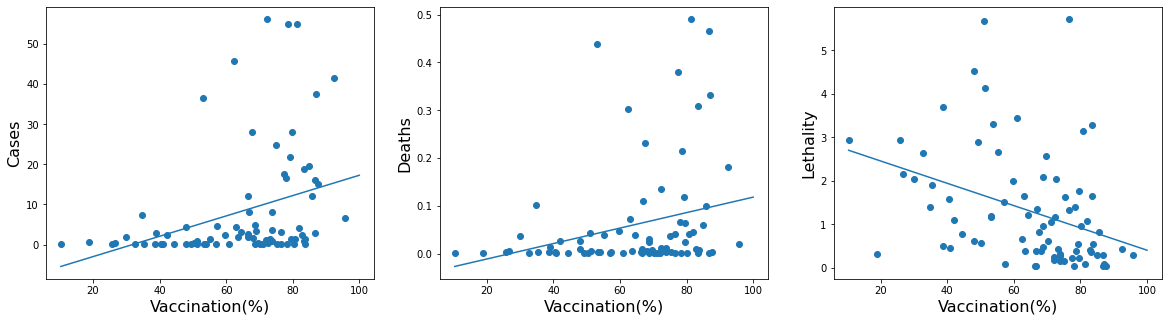

In [11]:
f, ax = plt.subplots(1,3, figsize=(20,5))

# Linear Regression을 활용해 선형 모델에 fitting
lr = LinearRegression()

x_val = ['Cases','Deaths','Lethality']
m = min(join_vac['Vaccinated%'])

for n in range(3):
    ax[n].scatter(join_vac['Vaccinated%'],join_vac[x_val[n]])
    x_train = np.array(join_vac['Vaccinated%']).reshape(-1,1)
    y_train = np.array(join_vac[x_val[n]]).reshape(-1,1)
    lr.fit(x_train,y_train)
    ax[n].plot([m,100], [m*float(lr.coef_) + lr.intercept_ , 100*lr.coef_ + lr.intercept_])
    ax[n].set_xlabel('Vaccination(%)', fontsize=16)
    ax[n].set_ylabel(x_val[n], fontsize=16)

plt.show()

## 국가별 개인 건강상태 지표

1. 국가별 개인의 건강한 삶의 기대값(years)

In [12]:
with pd.ExcelFile("data/whs2022.xlsx") as xls:
    df_whs1 = pd.read_excel(xls, "Annex 2-1")
df_whs1 = df_whs1.iloc[4:,[0,9]] # 국가별 개인의 건강한 삶의 기대값(years) 추출
df_whs1 = df_whs1[df_whs1 != '-'] # data값이 '-'로 표시된 나라를 NaN Value로 변경
df_whs1 = df_whs1.dropna() # NaN Value 제거
df_whs1.columns = ['','Healthy life expectancy']
df_whs1 = df_whs1.set_index('')
df_whs1.head()

,Healthy life expectancy
,
Afghanistan,53.9
Albania,69.1
Algeria,66.4
Angola,54.8
Antigua and Barbuda,67


- `key data`와 국가별 개인의 건강한 삶의 기댓값 병합

In [13]:
join_life = df_whs1.join(df_covid19, how='inner') # 백신 접종 현황과 확진자/사망자/치사율 data 병합
join_life.head()

,Healthy life expectancy,Cases,Deaths,Lethality
Albania,69.1,0.127,0.001,0.787402
Argentina,67.1,1.486,0.008,0.538358
Austria,70.9,24.840,0.037,0.148953
Azerbaijan,63.6,0.221,0.010,4.524887
Bahrain,65.9,1.087,0.002,0.183993


### 국가별 기대 수명과 코로나-19 확진자/사망자/치사율의 상관관계

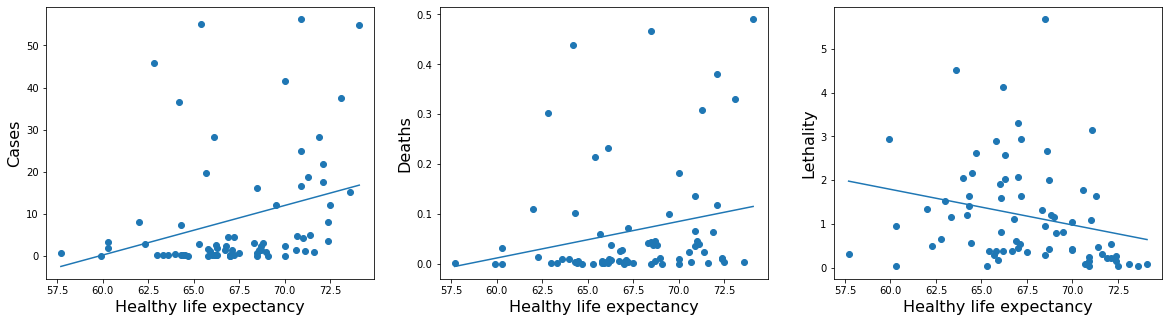

In [14]:
f, ax = plt.subplots(1,3, figsize=(20,5))

# Linear Regression을 활용해 선형 모델에 fitting
lr = LinearRegression()

x_val = ['Cases','Deaths','Lethality']
m = min(join_life['Healthy life expectancy'])
mx = max(join_life['Healthy life expectancy'])

for n in range(3):
    ax[n].scatter(join_life['Healthy life expectancy'],join_life[x_val[n]])
    x_train = np.array(join_life['Healthy life expectancy']).reshape(-1,1)
    y_train = np.array(join_life[x_val[n]]).reshape(-1,1)
    lr.fit(x_train,y_train)
    ax[n].plot([m,mx], [m*float(lr.coef_) + lr.intercept_ , mx*lr.coef_ + lr.intercept_])
    ax[n].set_xlabel('Healthy life expectancy', fontsize=16)
    ax[n].set_ylabel(x_val[n], fontsize=16)

plt.show()

2. 국가별 안전한(정수된) 물을 사용하는 인구 비율(%)

In [15]:
with pd.ExcelFile("data/whs2022.xlsx") as xls:
    df_whs2 = pd.read_excel(xls, "Annex 2-4")
df_whs2 = df_whs2.iloc[4:,[0,10]] # 국가별 정수된 물을 사용하는 인구 비율(%) 추출
df_whs2 = df_whs2[df_whs2 != '-'] # data값이 '-'로 표시된 나라를 NaN Value로 변경
df_whs2 = df_whs2.dropna() # NaN Value 제거
df_whs2.columns = ['','% using safe water']
df_whs2 = df_whs2[df_whs2['% using safe water'] <100] # 100%가 넘는 값(trash data) 제거
df_whs2 = df_whs2[df_whs2['% using safe water'] >0] # 0%인 data 제거
df_whs2 = df_whs2.set_index('')
df_whs2

,% using safe water
,
Afghanistan,28
Albania,71
Algeria,72
Andorra,91
Armenia,87
...,...
African Region,32
Region of the Americas,81
European Region,92


- `key data`와 국가별 안전한(정수된) 물을 사용하는 인구 비율 병합

In [16]:
join_water = df_whs2.join(df_covid19, how='inner') # 백신 접종 현황과 확진자/사망자/치사율 data 병합
join_water.head()

,% using safe water,Cases,Deaths,Lethality
Albania,71,0.127,0.001,0.787402
Andorra,91,0.160,0.001,0.625000
Austria,99,24.840,0.037,0.148953
Azerbaijan,88,0.221,0.010,4.524887
Bahrain,99,1.087,0.002,0.183993


### 국가별 정수된 물 사용과 코로나-19 확진자/사망자/치사율의 상관관계

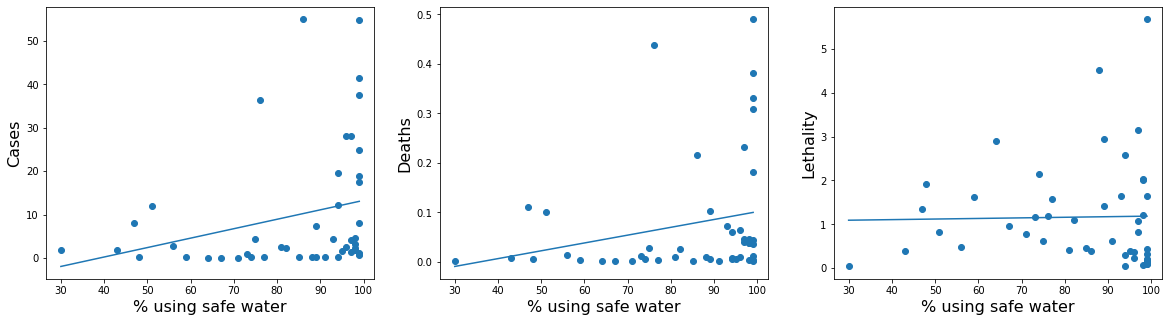

In [17]:
f, ax = plt.subplots(1,3, figsize=(20,5))

# Linear Regression을 활용해 선형 모델에 fitting
lr = LinearRegression()

x_val = ['Cases','Deaths','Lethality']
m = min(join_water['% using safe water'])
mx = max(join_water['% using safe water'])

for n in range(3):
    ax[n].scatter(join_water['% using safe water'],join_water[x_val[n]])
    x_train = np.array(join_water['% using safe water']).reshape(-1,1)
    y_train = np.array(join_water[x_val[n]]).reshape(-1,1)
    lr.fit(x_train,y_train)
    ax[n].plot([m,mx], [m*float(lr.coef_) + lr.intercept_ , mx*lr.coef_ + lr.intercept_])
    ax[n].set_xlabel('% using safe water', fontsize=16)
    ax[n].set_ylabel(x_val[n], fontsize=16)

plt.show()

## 국가별 의료 종사자 비율

In [18]:
with pd.ExcelFile("data/whs2022.xlsx") as xls:
    df_doc = pd.read_excel(xls, "Annex 2-3")
df_doc = df_doc.iloc[4:,[0,10]] # 국가별 10,000명 당 의료 종사자 수 추출
df_doc = df_doc[df_doc != '-'] # data값이 '-'로 표시된 나라를 NaN Value로 변경
df_doc = df_doc.dropna() # NaN Value 제거
df_doc.columns = ['','Density of doctors']
df_doc = df_doc[df_doc['Density of doctors'] >0.1] # 0인 data 제거
df_doc = df_doc.set_index('')
df_doc.head()

,Density of doctors
,
Afghanistan,2.5
Albania,18.8
Algeria,17.2
Andorra,33.3
Angola,2.1


- `key data`와 국가별 의료 종사자 비율 병합

In [19]:
join_doc = df_doc.join(df_covid19, how='inner') # 의료 종사자 비율과 확진자/사망자/치사율 data 병합
join_doc

,Density of doctors,Cases,Deaths,Lethality
Albania,18.8,0.1270,0.0010,0.787402
Andorra,33.3,0.1600,0.0010,0.625000
Argentina,40.6,1.4860,0.0080,0.538358
Austria,52.9,24.8400,0.0370,0.148953
Azerbaijan,31.7,0.2210,0.0100,4.524887
...,...,...,...,...
Ukraine,29.9,7.3170,0.1030,1.407681
United States of America,26.1,28.1955,0.2323,0.823890
Uruguay,49.4,0.8160,0.0030,0.367647
Venezuela (Bolivarian Republic of),17.3,0.3520,0.0020,0.568182


### 국가별 의료종사자 비율과 코로나-19 확진자/사망자/치사율의 상관관계

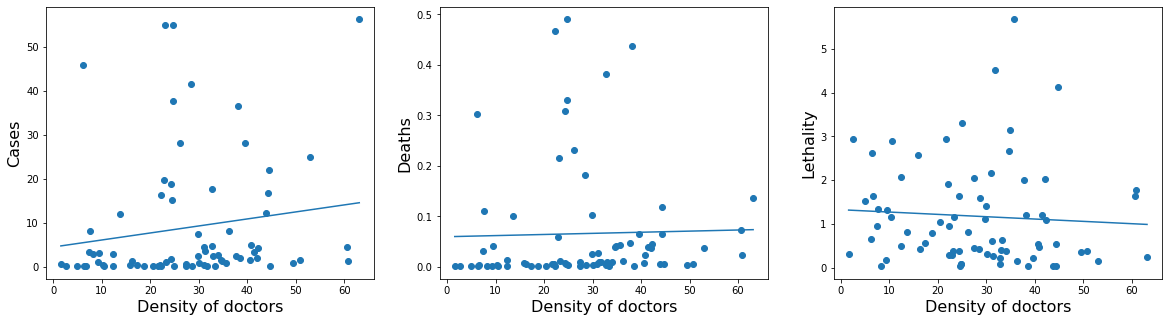

In [20]:
f, ax = plt.subplots(1,3, figsize=(20,5))

# Linear Regression을 활용해 선형 모델에 fitting
lr = LinearRegression()

x_val = ['Cases','Deaths','Lethality']
m = min(join_doc['Density of doctors'])
mx = max(join_doc['Density of doctors'])

for n in range(3):
    ax[n].scatter(join_doc['Density of doctors'],join_doc[x_val[n]])
    x_train = np.array(join_doc['Density of doctors']).reshape(-1,1)
    y_train = np.array(join_doc[x_val[n]]).reshape(-1,1)
    lr.fit(x_train,y_train)
    ax[n].plot([m,mx], [m*float(lr.coef_) + lr.intercept_ , mx*lr.coef_ + lr.intercept_])
    ax[n].set_xlabel('Density of doctors', fontsize=16)
    ax[n].set_ylabel(x_val[n], fontsize=16)

plt.show()

## 국가별 흡연율

In [21]:
with pd.ExcelFile("data/whs2022.xlsx") as xls:
    df_smkr = pd.read_excel(xls, "Annex 2-3")
df_smkr = df_smkr.iloc[4:,[0,1]] # 국가별 흡연율 추출
df_smkr = df_smkr[df_smkr != '-'] # data값이 '-'로 표시된 나라를 NaN Value로 변경
df_smkr = df_smkr.dropna() # NaN Value 제거
df_smkr.columns = ['','Smokers(%)']
df_smkr = df_smkr[df_smkr['Smokers(%)'] >0.1] # 0%인 data 제거
df_smkr = df_smkr.set_index('')
df_smkr.head()

,Smokers(%)
,
Afghanistan,23.3
Albania,22.4
Algeria,21
Andorra,31.8
Argentina,24.5


- `key data`와 국가별 흡연율 병합

In [22]:
join_smkr = df_smkr.join(df_covid19, how='inner') # 흡연자 비율과 확진자/사망자/치사율 data 병합
join_smkr

,Smokers(%),Cases,Deaths,Lethality
Albania,22.4,0.1270,0.0010,0.787402
Andorra,31.8,0.1600,0.0010,0.625000
Argentina,24.5,1.4860,0.0080,0.538358
Austria,26.4,24.8400,0.0370,0.148953
Azerbaijan,24,0.2210,0.0100,4.524887
...,...,...,...,...
Thailand,22.1,3.1660,0.0420,1.326595
Ukraine,25.8,7.3170,0.1030,1.407681
United States of America,23,28.1955,0.2323,0.823890
Uruguay,21.5,0.8160,0.0030,0.367647


### 국가별 흡연율과 코로나-19 확진자/사망자/치사율의 상관관계

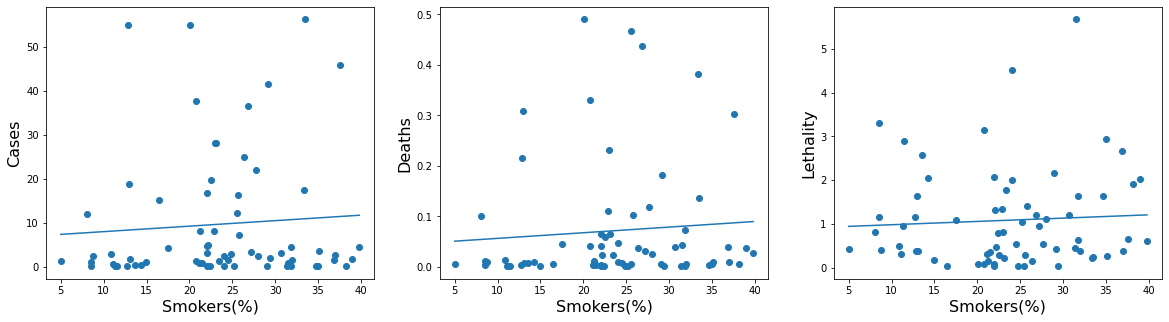

In [23]:
f, ax = plt.subplots(1,3, figsize=(20,5))

# Linear Regression을 활용해 선형 모델에 fitting
lr = LinearRegression()

x_val = ['Cases','Deaths','Lethality']
m = min(join_smkr['Smokers(%)'])
mx = max(join_smkr['Smokers(%)'])

for n in range(3):
    ax[n].scatter(join_smkr['Smokers(%)'],join_smkr[x_val[n]])
    x_train = np.array(join_smkr['Smokers(%)']).reshape(-1,1)
    y_train = np.array(join_smkr[x_val[n]]).reshape(-1,1)
    lr.fit(x_train,y_train)
    ax[n].plot([m,mx], [m*float(lr.coef_) + lr.intercept_ , mx*lr.coef_ + lr.intercept_])
    ax[n].set_xlabel('Smokers(%)', fontsize=16)
    ax[n].set_ylabel(x_val[n], fontsize=16)

plt.show()

## 국가별 1인당 알코올 음료 소비량

In [24]:
with pd.ExcelFile("data/whs2022.xlsx") as xls:
    df_alc = pd.read_excel(xls, "Annex 2-2")
df_alc = df_alc.iloc[4:,[0,3]] # 국가별 1인당 알코올 소비량 추출
df_alc = df_alc[df_alc != '-'] # data값이 '-'로 표시된 나라를 NaN Value로 변경
df_alc = df_alc[df_alc != '<0.1'] # data값이 '<0.1'로 표시된 나라를 NaN Value로 변경
df_alc = df_alc.dropna() # NaN Value 제거
df_alc.columns = ['','Alcohol consumption(l)']
df_alc = df_alc.set_index('')
df_alc.head()

,Alcohol consumption(l)
,
Albania,6.8
Algeria,0.6
Andorra,12.3
Angola,7.8
Antigua and Barbuda,9.4


- `key data`와 국가별 알코올 섭취량 병합

In [25]:
join_alc = df_alc.join(df_covid19, how='inner') # 알코올 소비량과 확진자/사망자/치사율 data 병합
join_alc

,Alcohol consumption(l),Cases,Deaths,Lethality
Albania,6.8,0.1270,0.0010,0.787402
Andorra,12.3,0.1600,0.0010,0.625000
Argentina,9.5,1.4860,0.0080,0.538358
Austria,11.9,24.8400,0.0370,0.148953
Azerbaijan,1,0.2210,0.0100,4.524887
...,...,...,...,...
Ukraine,8.3,7.3170,0.1030,1.407681
United States of America,10,28.1955,0.2323,0.823890
Uruguay,6.9,0.8160,0.0030,0.367647
Venezuela (Bolivarian Republic of),3.6,0.3520,0.0020,0.568182


### 국가별 알코올 섭취량과 코로나-19 확진자/사망자/치사율의 상관관계

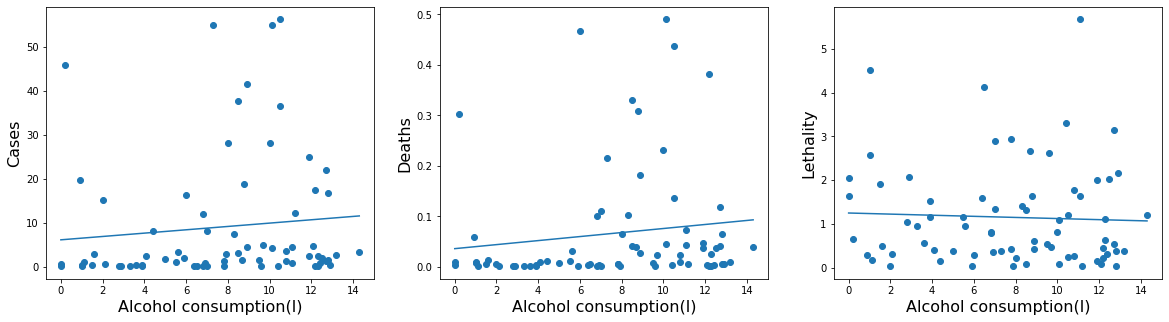

In [26]:
f, ax = plt.subplots(1,3, figsize=(20,5))

# Linear Regression을 활용해 선형 모델에 fitting
lr = LinearRegression()

x_val = ['Cases','Deaths','Lethality']
m = min(join_alc['Alcohol consumption(l)'])
mx = max(join_alc['Alcohol consumption(l)'])

for n in range(3):
    ax[n].scatter(join_alc['Alcohol consumption(l)'],join_alc[x_val[n]])
    x_train = np.array(join_alc['Alcohol consumption(l)']).reshape(-1,1)
    y_train = np.array(join_alc[x_val[n]]).reshape(-1,1)
    lr.fit(x_train,y_train)
    ax[n].plot([m,mx], [m*float(lr.coef_) + lr.intercept_ , mx*lr.coef_ + lr.intercept_])
    ax[n].set_xlabel('Alcohol consumption(l)', fontsize=16)
    ax[n].set_ylabel(x_val[n], fontsize=16)

plt.show()

## 국가별 HIV 감염자 수

In [27]:
with pd.ExcelFile("data/whs2022.xlsx") as xls:
    df_HIV = pd.read_excel(xls, "Annex 2-1")
df_HIV = df_HIV.iloc[4:,[0,15]] # 국가별 1인당 알코올 소비량 추출
df_HIV = df_HIV[df_HIV != '-'] # data값이 '-'로 표시된 나라를 NaN Value로 변경
df_HIV = df_HIV.dropna() # NaN Value 제거
df_HIV.columns = ['','HIV_infections(per1000)']
df_HIV = df_HIV.set_index('')
df_HIV

,HIV_infections(per1000)
,
Afghanistan,0.04
Albania,0.03
Algeria,0.04
Angola,0.69
Argentina,0.13
...,...
South-East Asia Region,0.05
European Region,0.18
Eastern Mediterranean Region,0.06


In [28]:
join_HIV = df_HIV.join(df_covid19, how='inner') # 흡연자 비율과 확진자/사망자/치사율 data 병합
join_HIV.head()

,HIV_infections(per1000),Cases,Deaths,Lethality
Albania,0.03,0.127,0.001,0.787402
Argentina,0.13,1.486,0.008,0.538358
Azerbaijan,0.04,0.221,0.010,4.524887
Bolivia (Plurinational State of),0.08,0.258,0.003,1.162791
Brazil,0.23,54.974,0.215,0.391094


### 국가별 HIV 감염자 비율과 코로나-19 확진자/사망자/치사율의 상관관계

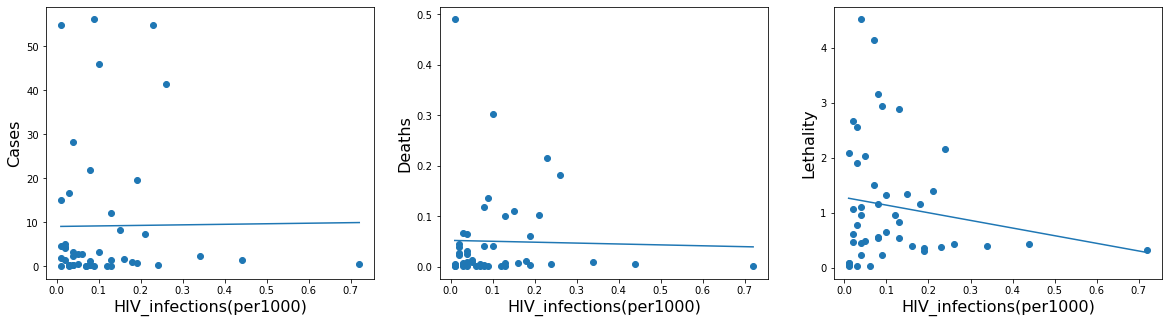

In [29]:
f, ax = plt.subplots(1,3, figsize=(20,5))

# Linear Regression을 활용해 선형 모델에 fitting
lr = LinearRegression()

x_val = ['Cases','Deaths','Lethality']
m = min(join_HIV['HIV_infections(per1000)'])
mx = max(join_HIV['HIV_infections(per1000)'])

for n in range(3):
    ax[n].scatter(join_HIV['HIV_infections(per1000)'],join_HIV[x_val[n]])
    x_train = np.array(join_HIV['HIV_infections(per1000)']).reshape(-1,1)
    y_train = np.array(join_HIV[x_val[n]]).reshape(-1,1)
    lr.fit(x_train,y_train)
    ax[n].plot([m,mx], [m*float(lr.coef_) + lr.intercept_ , mx*lr.coef_ + lr.intercept_])
    ax[n].set_xlabel('HIV_infections(per1000)', fontsize=16)
    ax[n].set_ylabel(x_val[n], fontsize=16)

plt.show()